## Imports

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load the Dataset

In [93]:
df = pd.read_parquet("res.pqt")
df = df[df['subject'] == 'professional_psychology']

## Topic Name

In [94]:
topic_name = "professional_psychology"  # or "professional_law", "high_school_macroeconomics", or "professional_psychology"

## Function to calculate the mean of the "corrects" for different sample sizes

In [ ]:
def compute_avg_correct_vs_sample_size(df, max_k=500, n=1000, seed=42):
    np.random.seed(seed)
    means = []
    for k in tqdm(range(1, max_k + 1), desc="Sample size loop"):
        trials = []
        for _ in range(n):
            sample = df.sample(n=k, replace=False)
            trials.append(sample['correct'].mean())
        means.append(np.mean(trials))
    return means

## Execution

In [ ]:
avg_means = compute_avg_correct_vs_sample_size(df, max_k=300, n=1000)
overall_mean = df['correct'].mean()
print("Overall mean of 'correct':", overall_mean)

Sample size loop: 100%|██████████| 300/300 [01:54<00:00,  2.62it/s]

Overall mean of 'correct': 0.8210180623973727


## Compute Sampling Baseline (Random)

We compute the average "correct" score over multiple random subsets of increasing size (k = 1 to N), repeated multiple times to simulate stability. This provides a reference curve against which smarter selection strategies will be compared.

In [ ]:
from tqdm import tqdm

def compute_avg_correct_vs_sample_size(df, max_k=300, n=1000, seed=42):
    np.random.seed(seed)
    means = []
    for k in tqdm(range(1, max_k + 1)):
        trials = []
        for _ in range(n):
            sample = df.sample(n=k, replace=False)
            trials.append(sample['correct'].mean())
        means.append(np.mean(trials))
    return list(range(1, max_k + 1)), means

# Filter dataset based on the selected topic
df_topic = df[df["subject"] == topic_name]

# Run the sampling procedure
k_values, avg_means = compute_avg_correct_vs_sample_size(df_topic, max_k=300, n=1000)
overall_mean = df_topic["correct"].mean()

100%|██████████| 300/300 [01:54<00:00,  2.61it/s]


## Save Results

In [ ]:
import json

results_df = pd.DataFrame({
    "k": k_values,
    "avg_sample_mean": avg_means
})

results_df.to_csv(f"sample_mean_results_{topic_name}.csv", index=False)
results_df.to_excel(f"sample_mean_results_{topic_name}.xlsx", index=False)

with open(f"sample_mean_results_{topic_name}.json", "w") as f:
    json.dump({
        "k_values": k_values,
        "avg_sample_mean": avg_means,
        "overall_mean": overall_mean,
        "topic": topic_name
    }, f)

## KMeans

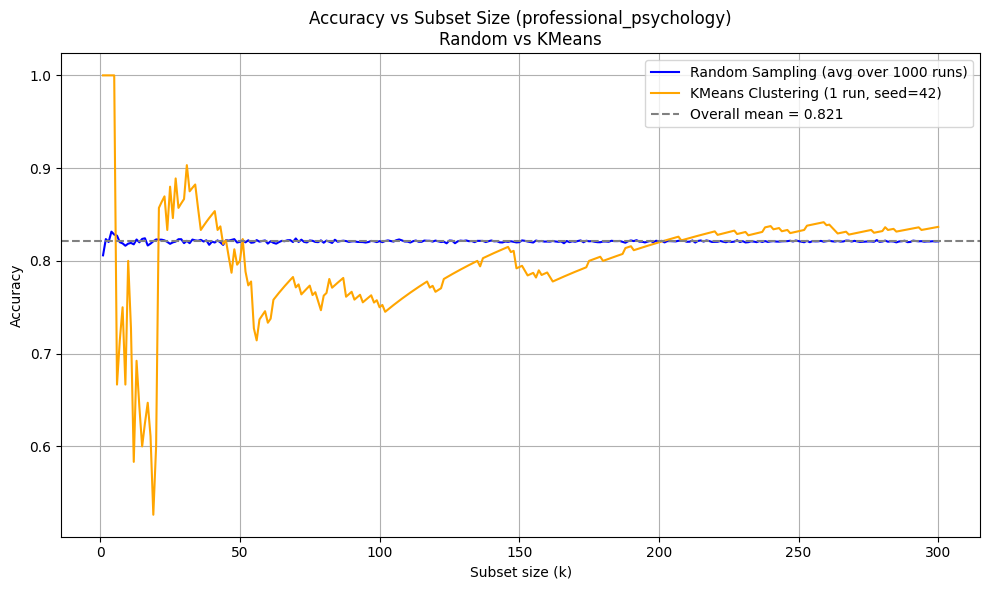

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Topic name
topic_name = "professional_psychology"  # es: "professional_law", "high_school_macroeconomics", or "professional_psychology"

# Carica i dati
df_random = pd.read_csv(f"sample_mean_results_{topic_name}.csv")
df_kmeans = pd.read_csv(f"kmeans_results_{topic_name}.csv")
overall_mean = df[df["subject"] == topic_name]["correct"].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_random["k"], df_random["avg_sample_mean"], label="Random Sampling (avg over 1000 runs)", color="blue")
plt.plot(df_kmeans["k"], df_kmeans["kmeans_accuracy"], label="KMeans Clustering (1 run, seed=42)", color="orange")
plt.axhline(y=overall_mean, color="gray", linestyle="--", label=f"Overall mean = {overall_mean:.3f}")

plt.xlabel("Subset size (k)")
plt.ylabel("Accuracy")
plt.title(f"Accuracy vs Subset Size ({topic_name})\nRandom vs KMeans")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"comparison_plot_{topic_name}.png", dpi=300)
plt.show()

# Note: Only 1 KMeans run per value of k is performed (with fixed seed) for reproducibility.
# Random sampling, instead, is averaged over 1000 repetitions.